# exp010_2
exp010をもう一度＋trainの予測結果を出力

In [1]:
# import library
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
import seaborn as sns
from tqdm.notebook import tqdm
import pathlib
import plotly
import plotly.express as px
import itertools
import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb

# utils

In [2]:
def calc_haversine(lat1, lon1, lat2, lon2):
    """Calculates the great circle distance between two points
    on the earth. Inputs are array-like and specified in decimal degrees.
    """
    RADIUS = 6_367_000
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + \
        np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    dist = 2 * RADIUS * np.arcsin(a**0.5)
    return dist

In [3]:
def visualize_trafic(df, center, zoom=9):
    fig = px.scatter_mapbox(df,
                            
                            # Here, plotly gets, (x,y) coordinates
                            lat="latDeg",
                            lon="lngDeg",
                            
                            #Here, plotly detects color of series
                            color="phoneName",
                            labels="phoneName",
                            
                            zoom=zoom,
                            center=center,
                            height=600,
                            width=800)
    fig.update_layout(mapbox_style='stamen-terrain')
    fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.update_layout(title_text="GPS trafic")
    fig.show()
    
def visualize_collection(df, collection):
    target_df = df[df['collectionName']==collection].copy()
    lat_center = target_df['latDeg'].mean()
    lng_center = target_df['lngDeg'].mean()
    center = {"lat":lat_center, "lon":lng_center}
    
    visualize_trafic(target_df, center)

# data prep

In [4]:
import ipynb_path

def get_nb_name():
    nb_path = ipynb_path.get()
    nb_name = nb_path.rsplit('/',1)[1].replace('.ipynb','')
    return nb_name

In [5]:
# directory setting
nb_name = get_nb_name()
INPUT = '../input/google-smartphone-decimeter-challenge'
OUTPUT = '../output/' + nb_name
os.makedirs(OUTPUT, exist_ok=True)

In [6]:
base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')

In [7]:
# ground_truth
p = pathlib.Path(INPUT)
gt_files = list(p.glob('train/*/*/ground_truth.csv'))
print('ground_truth.csv count : ', len(gt_files))

gts = []
for gt_file in tqdm(gt_files):
    gts.append(pd.read_csv(gt_file))
ground_truth = pd.concat(gts)

display(ground_truth.head())

ground_truth.csv count :  73


  0%|          | 0/73 [00:00<?, ?it/s]

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
0,2020-05-21-US-MTV-2,Pixel4,1274131364434,37.628927,-122.426295,65.36,64.43,2.6,0.0,0.0,154.3
1,2020-05-21-US-MTV-2,Pixel4,1274131365434,37.628927,-122.426295,65.36,65.43,2.6,0.0,0.0,154.3
2,2020-05-21-US-MTV-2,Pixel4,1274131366434,37.628927,-122.426295,65.36,66.43,2.6,0.0,0.0,154.3
3,2020-05-21-US-MTV-2,Pixel4,1274131367434,37.628927,-122.426295,65.36,67.43,2.6,0.0,0.0,154.3
4,2020-05-21-US-MTV-2,Pixel4,1274131368434,37.628927,-122.426295,65.36,68.43,2.6,0.0,0.0,154.3


# speed0の分類モデル

In [8]:
train = base_train.merge(ground_truth[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'speedMps']], on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')

In [9]:
train.loc[train['speedMps']==0.0, 'isSpeed0'] = 1
train['isSpeed0'] = train['isSpeed0'].fillna(0)

In [10]:
def add_features(df):
    for c,i in itertools.product(['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM'], [1,2,3,-1,-2,-3]):
        col = c+ '_s' + str(i)
        df[col] = df[c].shift(i)
        df[col+'_diff'] = df[c] - df[col]
        df.loc[df['phone']!=df['phone'].shift(i), [col, col+'_diff']] = np.nan
    
    for c in ['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']:
        df[c+'_s1_diff_sum'] = df[c+'_s1_diff'].fillna(0) + df[c+'_s-1_diff'].fillna(0)
        df[c+'_s2_diff_sum'] = df[c+'_s1_diff_sum'] + df[c+'_s2_diff'].fillna(0) + df[c+'_s-2_diff'].fillna(0)
        df[c+'_s3_diff_sum'] = df[c+'_s2_diff_sum'] + df[c+'_s3_diff'].fillna(0) + df[c+'_s-3_diff'].fillna(0)
    
    return df

In [11]:
train = add_features(train)
test = add_features(base_test)

In [12]:
train.columns

Index(['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg',
       'lngDeg', 'heightAboveWgs84EllipsoidM', 'phone', 'speedMps', 'isSpeed0',
       'latDeg_s1', 'latDeg_s1_diff', 'latDeg_s2', 'latDeg_s2_diff',
       'latDeg_s3', 'latDeg_s3_diff', 'latDeg_s-1', 'latDeg_s-1_diff',
       'latDeg_s-2', 'latDeg_s-2_diff', 'latDeg_s-3', 'latDeg_s-3_diff',
       'lngDeg_s1', 'lngDeg_s1_diff', 'lngDeg_s2', 'lngDeg_s2_diff',
       'lngDeg_s3', 'lngDeg_s3_diff', 'lngDeg_s-1', 'lngDeg_s-1_diff',
       'lngDeg_s-2', 'lngDeg_s-2_diff', 'lngDeg_s-3', 'lngDeg_s-3_diff',
       'heightAboveWgs84EllipsoidM_s1', 'heightAboveWgs84EllipsoidM_s1_diff',
       'heightAboveWgs84EllipsoidM_s2', 'heightAboveWgs84EllipsoidM_s2_diff',
       'heightAboveWgs84EllipsoidM_s3', 'heightAboveWgs84EllipsoidM_s3_diff',
       'heightAboveWgs84EllipsoidM_s-1', 'heightAboveWgs84EllipsoidM_s-1_diff',
       'heightAboveWgs84EllipsoidM_s-2', 'heightAboveWgs84EllipsoidM_s-2_diff',
       'heightAboveWgs84Ellip

In [13]:
target = 'isSpeed0'
not_use_cols = ['speedMps', 'collectionName', 'phoneName', 'phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM',
                'latDeg_s1', 'latDeg_s2', 'latDeg_s3', 'latDeg_s-1', 'latDeg_s-2',
                'latDeg_s-3', 'lngDeg_s1', 'lngDeg_s2', 'lngDeg_s3', 'lngDeg_s-1',
                'lngDeg_s-2', 'lngDeg_s-3', 'heightAboveWgs84EllipsoidM_s1',
                'heightAboveWgs84EllipsoidM_s2', 'heightAboveWgs84EllipsoidM_s3',
                'heightAboveWgs84EllipsoidM_s-1', 'heightAboveWgs84EllipsoidM_s-2',
                'heightAboveWgs84EllipsoidM_s-3', target]
features = [c for c in train.columns if c not in not_use_cols]
features

['latDeg_s1_diff',
 'latDeg_s2_diff',
 'latDeg_s3_diff',
 'latDeg_s-1_diff',
 'latDeg_s-2_diff',
 'latDeg_s-3_diff',
 'lngDeg_s1_diff',
 'lngDeg_s2_diff',
 'lngDeg_s3_diff',
 'lngDeg_s-1_diff',
 'lngDeg_s-2_diff',
 'lngDeg_s-3_diff',
 'heightAboveWgs84EllipsoidM_s1_diff',
 'heightAboveWgs84EllipsoidM_s2_diff',
 'heightAboveWgs84EllipsoidM_s3_diff',
 'heightAboveWgs84EllipsoidM_s-1_diff',
 'heightAboveWgs84EllipsoidM_s-2_diff',
 'heightAboveWgs84EllipsoidM_s-3_diff',
 'latDeg_s1_diff_sum',
 'latDeg_s2_diff_sum',
 'latDeg_s3_diff_sum',
 'lngDeg_s1_diff_sum',
 'lngDeg_s2_diff_sum',
 'lngDeg_s3_diff_sum',
 'heightAboveWgs84EllipsoidM_s1_diff_sum',
 'heightAboveWgs84EllipsoidM_s2_diff_sum',
 'heightAboveWgs84EllipsoidM_s3_diff_sum']

# optuna_lgb_tuner

In [14]:
params = {'objective': 'binary',
          'learning_rate': 0.1,
          'seed':42}

collections = train['collectionName'].unique()

oof = pd.DataFrame()
imp = pd.DataFrame()

for collection in collections:
    print('valid : ', collection)
    tr_idx = train[train['collectionName']!=collection].index
    vl_idx = train[train['collectionName']==collection].index
    tr_x, tr_y = train[features].iloc[tr_idx], train[target].iloc[tr_idx]
    vl_x, vl_y = train[features].iloc[vl_idx], train[target].iloc[vl_idx]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    
    break
    
tuner = optuna_lgb.train(params, tr_data, valid_sets=[tr_data, vl_data],
                         num_boost_round=20000, early_stopping_rounds=100, verbose_eval=100)
opt_params = tuner.params

[I 2021-06-10 10:39:53,028] A new study created in memory with name: no-name-e0e9e963-0b77-4b90-8ad1-ae4d7ebf28f5
feature_fraction, val_score: inf:   0%|          | 0/7 [00:00<?, ?it/s]

valid :  2020-05-14-US-MTV-1
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0591238	valid_1's binary_logloss: 0.0174769
[200]	valid_0's binary_logloss: 0.046614	valid_1's binary_logloss: 0.0170122
[300]	valid_0's binary_logloss: 0.0381255	valid_1's binary_logloss: 0.0169724
[400]	valid_0's binary_logloss: 0.0314267	valid_1's binary_logloss: 0.0167575


feature_fraction, val_score: 0.016568:  14%|#4        | 1/7 [00:02<00:17,  2.94s/it]

[500]	valid_0's binary_logloss: 0.0262921	valid_1's binary_logloss: 0.0167085
Early stopping, best iteration is:
[438]	valid_0's binary_logloss: 0.0293872	valid_1's binary_logloss: 0.0165685
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004982 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0585941	valid_1's binary_logloss: 0.0171041
[200]	valid_0's binary_logloss: 0.046159	valid_1's binary_logloss: 0.0170706
[300]	valid_0's binary_logloss: 0.0379244	valid_1's binary_logloss: 0.0170857


feature_fraction, val_score: 0.016568:  29%|##8       | 2/7 [00:04<00:11,  2.28s/it]

Early stopping, best iteration is:
[266]	valid_0's binary_logloss: 0.0402761	valid_1's binary_logloss: 0.0169411
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000934 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.061987	valid_1's binary_logloss: 0.0181758
[200]	valid_0's binary_logloss: 0.0507953	valid_1's binary_logloss: 0.01774
[300]	valid_0's binary_logloss: 0.042295	valid_1's binary_logloss: 0.0175192
[400]	valid_0's binary_logloss: 

feature_fraction, val_score: 0.016568:  43%|####2     | 3/7 [00:08<00:11,  2.86s/it]

Early stopping, best iteration is:
[469]	valid_0's binary_logloss: 0.0320917	valid_1's binary_logloss: 0.0169462
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004712 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0600603	valid_1's binary_logloss: 0.0182559
[200]	valid_0's binary_logloss: 0.0477648	valid_1's binary_logloss: 0.0175904
[300]	valid_0's binary_logloss: 0.0393322	valid_1's binary_logloss: 0.0172925
[400]	valid_0's binary_logloss: 0.0326914	valid_1's binary_logloss: 0.0172721
[500]	valid_0'

feature_fraction, val_score: 0.016568:  57%|#####7    | 4/7 [00:11<00:08,  2.94s/it]

Early stopping, best iteration is:
[468]	valid_0's binary_logloss: 0.0289625	valid_1's binary_logloss: 0.0169923
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0604354	valid_1's binary_logloss: 0.018264
[200]	valid_0's binary_logloss: 0.0486625	valid_1's binary_logloss: 0.0176425


feature_fraction, val_score: 0.016568:  71%|#######1  | 5/7 [00:13<00:05,  2.62s/it]

Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.0487079	valid_1's binary_logloss: 0.0176222
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0594048	valid_1's binary_logloss: 0.0179061


feature_fraction, val_score: 0.016568:  86%|########5 | 6/7 [00:14<00:02,  2.16s/it]

[200]	valid_0's binary_logloss: 0.0472929	valid_1's binary_logloss: 0.017504
Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.0528864	valid_1's binary_logloss: 0.0174595


[I 2021-06-10 10:40:07,734] Trial 5 finished with value: 0.01745952193892891 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.016568476415775402.
feature_fraction, val_score: 0.016568:  86%|########5 | 6/7 [00:14<00:02,  2.16s/it]

[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.060821	valid_1's binary_logloss: 0.0171948
[200]	valid_0's binary_logloss: 0.0491628	valid_1's binary_logloss: 0.0167558


num_leaves, val_score: 0.016568:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.0509665	valid_1's binary_logloss: 0.0166357
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0615693	valid_1's binary_logloss: 0.0173135
[200]	valid_0's binary_logloss: 0.0503943	valid_1's binary_logloss: 0.0171165
[300]	valid_0's binary_logloss: 0.0426742	valid_1's binary_logloss: 0.0165889
[400]	valid_0's binary_logloss: 0.0363341	valid_1's binary_logloss: 0.0162244


num_leaves, val_score: 0.016204:   5%|5         | 1/20 [00:02<00:42,  2.24s/it]

Early stopping, best iteration is:
[393]	valid_0's binary_logloss: 0.0366944	valid_1's binary_logloss: 0.016204
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.101665	valid_1's binary_logloss: 0.0333574
[200]	valid_0's binary_logloss: 0.0886123	valid_1's binary_logloss: 0.02541
[300]	valid_0's binary_logloss: 0.0830554	valid_1's binary_logloss: 0.0226049
[400]	valid_0's binary_logloss: 0.0795408	valid_1's binary_logloss: 0.0215527
[500]	valid_0's bi

num_leaves, val_score: 0.016204:  10%|#         | 2/20 [00:10<01:48,  6.02s/it]

Early stopping, best iteration is:
[3330]	valid_0's binary_logloss: 0.0623672	valid_1's binary_logloss: 0.0184971
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006722 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.042149	valid_1's binary_logloss: 0.0162922
[200]	valid_0's binary_logloss: 0.0259567	valid_1's binary_logloss: 0.0157443


num_leaves, val_score: 0.015708:  15%|#5        | 3/20 [00:13<01:17,  4.58s/it]

[300]	valid_0's binary_logloss: 0.0161476	valid_1's binary_logloss: 0.0160625
Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 0.0256007	valid_1's binary_logloss: 0.0157078
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004751 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0153826	valid_1's binary_logloss: 0.0161241


num_leaves, val_score: 0.015708:  20%|##        | 4/20 [00:17<01:08,  4.26s/it]

Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.0166135	valid_1's binary_logloss: 0.015979
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004774 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0377895	valid_1's binary_logloss: 0.0163931


num_leaves, val_score: 0.015708:  25%|##5       | 5/20 [00:19<00:49,  3.33s/it]

Early stopping, best iteration is:
[87]	valid_0's binary_logloss: 0.0412489	valid_1's binary_logloss: 0.0161944
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.025383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0187462	valid_1's binary_logloss: 0.0166533


num_leaves, val_score: 0.015708:  30%|###       | 6/20 [00:22<00:46,  3.32s/it]

Early stopping, best iteration is:
[78]	valid_0's binary_logloss: 0.025153	valid_1's binary_logloss: 0.0163389
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0149196	valid_1's binary_logloss: 0.0163541


num_leaves, val_score: 0.015708:  35%|###5      | 7/20 [00:25<00:42,  3.30s/it]

Early stopping, best iteration is:
[67]	valid_0's binary_logloss: 0.0250111	valid_1's binary_logloss: 0.0158613
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0800862	valid_1's binary_logloss: 0.0225523
[200]	valid_0's binary_logloss: 0.0732535	valid_1's binary_logloss: 0.0201284
[300]	valid_0's binary_logloss: 0.0697727	valid_1's binary_logloss: 0.0194167
[400]	valid_0's binary_logloss: 0.0670986	valid_1's binary_logloss: 0.0189998
[500]	valid_0's

num_leaves, val_score: 0.015708:  40%|####      | 8/20 [00:29<00:41,  3.44s/it]

[1200]	valid_0's binary_logloss: 0.0523411	valid_1's binary_logloss: 0.0175796
Early stopping, best iteration is:
[1109]	valid_0's binary_logloss: 0.0535874	valid_1's binary_logloss: 0.0175472
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.088436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0496114	valid_1's binary_logloss: 0.0173603


num_leaves, val_score: 0.015708:  45%|####5     | 9/20 [00:31<00:31,  2.91s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0540104	valid_1's binary_logloss: 0.0171313
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0156131	valid_1's binary_logloss: 0.0165976
[200]	valid_0's binary_logloss: 0.00423499	valid_1's binary_logloss: 0.0184018


num_leaves, val_score: 0.015708:  50%|#####     | 10/20 [00:35<00:32,  3.24s/it]

Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.0127247	valid_1's binary_logloss: 0.016377
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005075 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0258437	valid_1's binary_logloss: 0.0166284


num_leaves, val_score: 0.015708:  55%|#####5    | 11/20 [00:38<00:27,  3.10s/it]

Early stopping, best iteration is:
[80]	valid_0's binary_logloss: 0.0316156	valid_1's binary_logloss: 0.0164941
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004752 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0293445	valid_1's binary_logloss: 0.0162334
[200]	valid_0's binary_logloss: 0.0134637	valid_1's binary_logloss: 0.0165745


num_leaves, val_score: 0.015708:  60%|######    | 12/20 [00:41<00:24,  3.08s/it]

Early stopping, best iteration is:
[137]	valid_0's binary_logloss: 0.0220184	valid_1's binary_logloss: 0.0160324
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0416734	valid_1's binary_logloss: 0.0166427
[200]	valid_0's binary_logloss: 0.0254023	valid_1's binary_logloss: 0.0162493
[300]	valid_0's binary_logloss: 0.0159105	valid_1's binary_logloss: 0.0164606


num_leaves, val_score: 0.015708:  65%|######5   | 13/20 [00:44<00:21,  3.12s/it]

Early stopping, best iteration is:
[239]	valid_0's binary_logloss: 0.0210985	valid_1's binary_logloss: 0.0160293
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005565 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0251841	valid_1's binary_logloss: 0.0162954
[200]	valid_0's binary_logloss: 0.00962059	valid_1's binary_logloss: 0.0163826


num_leaves, val_score: 0.015708:  70%|#######   | 14/20 [00:47<00:19,  3.26s/it]

Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.0157983	valid_1's binary_logloss: 0.015785
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0248346	valid_1's binary_logloss: 0.016418


num_leaves, val_score: 0.015708:  75%|#######5  | 15/20 [00:51<00:16,  3.31s/it]

Early stopping, best iteration is:
[93]	valid_0's binary_logloss: 0.0264805	valid_1's binary_logloss: 0.0163225
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005002 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.031172	valid_1's binary_logloss: 0.0167806
[200]	valid_0's binary_logloss: 0.0144643	valid_1's binary_logloss: 0.0165717


num_leaves, val_score: 0.015708:  80%|########  | 16/20 [00:54<00:13,  3.36s/it]

Early stopping, best iteration is:
[181]	valid_0's binary_logloss: 0.0166018	valid_1's binary_logloss: 0.0163142
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004753 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0197206	valid_1's binary_logloss: 0.0170879


num_leaves, val_score: 0.015708:  85%|########5 | 17/20 [00:57<00:09,  3.22s/it]

Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.0291041	valid_1's binary_logloss: 0.0167383
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0392293	valid_1's binary_logloss: 0.0170366


num_leaves, val_score: 0.015708:  90%|######### | 18/20 [00:59<00:05,  2.72s/it]

Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.0457579	valid_1's binary_logloss: 0.0165352
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0216449	valid_1's binary_logloss: 0.01695


num_leaves, val_score: 0.015708:  95%|#########5| 19/20 [01:02<00:02,  2.92s/it]

Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.0285157	valid_1's binary_logloss: 0.0165798
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002213 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0350292	valid_1's binary_logloss: 0.0162489
[200]	valid_0's binary_logloss: 0.0185533	valid_1's binary_logloss: 0.0163604


bagging, val_score: 0.015708:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping, best iteration is:
[161]	valid_0's binary_logloss: 0.0235018	valid_1's binary_logloss: 0.0160089
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0417443	valid_1's binary_logloss: 0.0162365
[200]	valid_0's binary_logloss: 0.0237757	valid_1's binary_logloss: 0.0168686


bagging, val_score: 0.015708:  10%|#         | 1/10 [00:01<00:16,  1.88s/it]

Early stopping, best iteration is:
[141]	valid_0's binary_logloss: 0.0326934	valid_1's binary_logloss: 0.0160626
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0413346	valid_1's binary_logloss: 0.0167231


bagging, val_score: 0.015708:  20%|##        | 2/10 [00:03<00:14,  1.79s/it]

Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.0419791	valid_1's binary_logloss: 0.0166516
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004760 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0431728	valid_1's binary_logloss: 0.0177752
[200]	valid_0's binary_logloss: 0.0247832	valid_1's binary_logloss: 0.0171067


bagging, val_score: 0.015708:  30%|###       | 3/10 [00:05<00:13,  1.96s/it]

[300]	valid_0's binary_logloss: 0.0148903	valid_1's binary_logloss: 0.0182249
Early stopping, best iteration is:
[207]	valid_0's binary_logloss: 0.0238268	valid_1's binary_logloss: 0.017013
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0431167	valid_1's binary_logloss: 0.0175754


bagging, val_score: 0.015708:  40%|####      | 4/10 [00:07<00:10,  1.75s/it]

Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.0468366	valid_1's binary_logloss: 0.0171163
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0416696	valid_1's binary_logloss: 0.0175137


bagging, val_score: 0.015708:  50%|#####     | 5/10 [00:08<00:08,  1.74s/it]

[200]	valid_0's binary_logloss: 0.0237984	valid_1's binary_logloss: 0.0180132
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.0387486	valid_1's binary_logloss: 0.0172895
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0416385	valid_1's binary_logloss: 0.0164718
[200]	valid_0's binary_logloss: 0.0254578	valid_1's binary_logloss: 0.0165147
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.0363045	valid_1's binar

bagging, val_score: 0.015708:  60%|######    | 6/10 [00:10<00:07,  1.81s/it]

[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004806 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0413613	valid_1's binary_logloss: 0.0178044
[200]	valid_0's binary_logloss: 0.0231831	valid_1's binary_logloss: 0.017737


bagging, val_score: 0.015708:  70%|#######   | 7/10 [00:13<00:05,  1.95s/it]

Early stopping, best iteration is:
[167]	valid_0's binary_logloss: 0.0279025	valid_1's binary_logloss: 0.0171239
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0412338	valid_1's binary_logloss: 0.0177247


bagging, val_score: 0.015708:  80%|########  | 8/10 [00:14<00:03,  1.89s/it]

Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.0425498	valid_1's binary_logloss: 0.0175306
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0417095	valid_1's binary_logloss: 0.0168931
[200]	valid_0's binary_logloss: 0.0237955	valid_1's binary_logloss: 0.0170904


bagging, val_score: 0.015708:  90%|######### | 9/10 [00:16<00:01,  1.87s/it]

Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.0322743	valid_1's binary_logloss: 0.0166386
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004679 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0419391	valid_1's binary_logloss: 0.0168094
[200]	valid_0's binary_logloss: 0.024519	valid_1's binary_logloss: 0.0167125


feature_fraction_stage2, val_score: 0.015708:   0%|          | 0/6 [00:00<?, ?it/s]

Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.0336375	valid_1's binary_logloss: 0.0165648
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004970 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0417297	valid_1's binary_logloss: 0.0162206
[200]	valid_0's binary_logloss: 0.0254074	valid_1's binary_logloss: 0.0160862


feature_fraction_stage2, val_score: 0.015708:  17%|#6        | 1/6 [00:02<00:11,  2.21s/it]

Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.0314694	valid_1's binary_logloss: 0.0160228
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0420052	valid_1's binary_logloss: 0.0166595


feature_fraction_stage2, val_score: 0.015708:  33%|###3      | 2/6 [00:04<00:08,  2.03s/it]

[200]	valid_0's binary_logloss: 0.0255874	valid_1's binary_logloss: 0.0172235
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.0414157	valid_1's binary_logloss: 0.0166213
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0424969	valid_1's binary_logloss: 0.0168569
[200]	valid_0's binary_logloss: 0.0259788	valid_1's binary_logloss: 0.0160711
[300]	valid_0's binary_logloss: 0.0165398	valid_1's binary_logloss: 0.0161897


feature_fraction_stage2, val_score: 0.015708:  50%|#####     | 3/6 [00:08<00:09,  3.12s/it]

Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.0214766	valid_1's binary_logloss: 0.0157186
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0415888	valid_1's binary_logloss: 0.0169417
[200]	valid_0's binary_logloss: 0.0252681	valid_1's binary_logloss: 0.0164188
[300]	valid_0's binary_logloss: 0.0160824	valid_1's binary_logloss: 0.0163498


feature_fraction_stage2, val_score: 0.015708:  67%|######6   | 4/6 [00:12<00:06,  3.43s/it]

Early stopping, best iteration is:
[296]	valid_0's binary_logloss: 0.0164402	valid_1's binary_logloss: 0.0163334
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005519 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.042149	valid_1's binary_logloss: 0.0162922
[200]	valid_0's binary_logloss: 0.0259567	valid_1's binary_logloss: 0.0157443


feature_fraction_stage2, val_score: 0.015708:  83%|########3 | 5/6 [00:15<00:03,  3.22s/it]

[300]	valid_0's binary_logloss: 0.0161476	valid_1's binary_logloss: 0.0160625
Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 0.0256007	valid_1's binary_logloss: 0.0157078
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004819 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0417297	valid_1's binary_logloss: 0.0162206
[200]	valid_0's binary_logloss: 0.0254074	valid_1's binary_logloss: 0.0160862


regularization_factors, val_score: 0.015708:   0%|          | 0/20 [00:00<?, ?it/s]

Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.0314694	valid_1's binary_logloss: 0.0160228
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0421491	valid_1's binary_logloss: 0.016267
[200]	valid_0's binary_logloss: 0.02571	valid_1's binary_logloss: 0.0158712


regularization_factors, val_score: 0.015708:   5%|5         | 1/20 [00:02<00:48,  2.53s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.0309731	valid_1's binary_logloss: 0.0157534
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0427369	valid_1's binary_logloss: 0.0169905
[200]	valid_0's binary_logloss: 0.0265818	valid_1's binary_logloss: 0.0165231
[300]	valid_0's binary_logloss: 0.0175627	valid_1's binary_logloss: 0.0165089


regularization_factors, val_score: 0.015708:  10%|#         | 2/20 [00:05<00:50,  2.81s/it]

Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.0201299	valid_1's binary_logloss: 0.0163753
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004978 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0454178	valid_1's binary_logloss: 0.0160513


regularization_factors, val_score: 0.015708:  15%|#5        | 3/20 [00:07<00:40,  2.40s/it]

[200]	valid_0's binary_logloss: 0.0307219	valid_1's binary_logloss: 0.0161378
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.0419943	valid_1's binary_logloss: 0.0158204
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.042294	valid_1's binary_logloss: 0.0167094


regularization_factors, val_score: 0.015708:  20%|##        | 4/20 [00:09<00:34,  2.17s/it]

[200]	valid_0's binary_logloss: 0.0259413	valid_1's binary_logloss: 0.017199
Early stopping, best iteration is:
[126]	valid_0's binary_logloss: 0.0368123	valid_1's binary_logloss: 0.0165239
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.042245	valid_1's binary_logloss: 0.0158485
[200]	valid_0's binary_logloss: 0.0254933	valid_1's binary_logloss: 0.0154438


regularization_factors, val_score: 0.015229:  25%|##5       | 5/20 [00:11<00:32,  2.17s/it]

Early stopping, best iteration is:
[175]	valid_0's binary_logloss: 0.0284082	valid_1's binary_logloss: 0.0152292
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0426307	valid_1's binary_logloss: 0.0165912
[200]	valid_0's binary_logloss: 0.0263775	valid_1's binary_logloss: 0.0167675
[300]	valid_0's binary_logloss: 0.0174717	valid_1's binary_logloss: 0.0165569


regularization_factors, val_score: 0.015229:  30%|###       | 6/20 [00:14<00:35,  2.54s/it]

Early stopping, best iteration is:
[282]	valid_0's binary_logloss: 0.0188852	valid_1's binary_logloss: 0.016216
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0489962	valid_1's binary_logloss: 0.0162138
[200]	valid_0's binary_logloss: 0.0345524	valid_1's binary_logloss: 0.0162152


regularization_factors, val_score: 0.015229:  35%|###5      | 7/20 [00:17<00:33,  2.60s/it]

Early stopping, best iteration is:
[145]	valid_0's binary_logloss: 0.041501	valid_1's binary_logloss: 0.0159707
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0447721	valid_1's binary_logloss: 0.0163413


regularization_factors, val_score: 0.015229:  40%|####      | 8/20 [00:19<00:27,  2.33s/it]

[200]	valid_0's binary_logloss: 0.029511	valid_1's binary_logloss: 0.0165031
Early stopping, best iteration is:
[105]	valid_0's binary_logloss: 0.0437688	valid_1's binary_logloss: 0.0163278
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0421491	valid_1's binary_logloss: 0.0162801
[200]	valid_0's binary_logloss: 0.0259505	valid_1's binary_logloss: 0.0158136
[300]	valid_0's binary_logloss: 0.0165311	valid_1's binary_logloss: 0.0158132


regularization_factors, val_score: 0.015229:  45%|####5     | 9/20 [00:21<00:27,  2.47s/it]

Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.0203355	valid_1's binary_logloss: 0.0157203
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0418556	valid_1's binary_logloss: 0.0160613


regularization_factors, val_score: 0.015229:  50%|#####     | 10/20 [00:23<00:22,  2.22s/it]

Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.0421661	valid_1's binary_logloss: 0.0160358
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0421491	valid_1's binary_logloss: 0.0162922
[200]	valid_0's binary_logloss: 0.0259503	valid_1's binary_logloss: 0.0158184
[300]	valid_0's binary_logloss: 0.016285	valid_1's binary_logloss: 0.0160973


regularization_factors, val_score: 0.015229:  55%|#####5    | 11/20 [00:26<00:21,  2.41s/it]

Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.0208675	valid_1's binary_logloss: 0.0156882
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004718 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0421491	valid_1's binary_logloss: 0.0162922
[200]	valid_0's binary_logloss: 0.0259503	valid_1's binary_logloss: 0.0158169
[300]	valid_0's binary_logloss: 0.016285	valid_1's binary_logloss: 0.016098


regularization_factors, val_score: 0.015229:  60%|######    | 12/20 [00:29<00:21,  2.65s/it]

Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.0208675	valid_1's binary_logloss: 0.0156871
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005416 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.041936	valid_1's binary_logloss: 0.0164941


regularization_factors, val_score: 0.015229:  65%|######5   | 13/20 [00:31<00:16,  2.39s/it]

[200]	valid_0's binary_logloss: 0.0256064	valid_1's binary_logloss: 0.0169189
Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.0385354	valid_1's binary_logloss: 0.0163363
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004986 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0421491	valid_1's binary_logloss: 0.0162922
[200]	valid_0's binary_logloss: 0.0259503	valid_1's binary_logloss: 0.0158211
[300]	valid_0's binary_logloss: 0.016285	valid_1's binary_logloss: 0.0160998


regularization_factors, val_score: 0.015229:  70%|#######   | 14/20 [00:34<00:15,  2.52s/it]

Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.0208675	valid_1's binary_logloss: 0.0156906
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0422721	valid_1's binary_logloss: 0.0158609


regularization_factors, val_score: 0.015229:  75%|#######5  | 15/20 [00:36<00:11,  2.33s/it]

[200]	valid_0's binary_logloss: 0.0254736	valid_1's binary_logloss: 0.0160694
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.0416931	valid_1's binary_logloss: 0.015743
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.042149	valid_1's binary_logloss: 0.0162922
[200]	valid_0's binary_logloss: 0.0259098	valid_1's binary_logloss: 0.0158435
[300]	valid_0's binary_logloss: 0.0164828	valid_1's binary_logloss: 0.0157096


regularization_factors, val_score: 0.015229:  80%|########  | 16/20 [00:39<00:11,  2.77s/it]

[400]	valid_0's binary_logloss: 0.0102873	valid_1's binary_logloss: 0.0161116
Early stopping, best iteration is:
[305]	valid_0's binary_logloss: 0.0161474	valid_1's binary_logloss: 0.0156455
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.042149	valid_1's binary_logloss: 0.0162946
[200]	valid_0's binary_logloss: 0.0257099	valid_1's binary_logloss: 0.0158825


regularization_factors, val_score: 0.015229:  85%|########5 | 17/20 [00:42<00:08,  2.69s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.030973	valid_1's binary_logloss: 0.0157716
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0421492	valid_1's binary_logloss: 0.0162801
[200]	valid_0's binary_logloss: 0.0257101	valid_1's binary_logloss: 0.0158794


regularization_factors, val_score: 0.015229:  90%|######### | 18/20 [00:44<00:05,  2.60s/it]

Early stopping, best iteration is:
[160]	valid_0's binary_logloss: 0.0309732	valid_1's binary_logloss: 0.0157675
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.042149	valid_1's binary_logloss: 0.0162922
[200]	valid_0's binary_logloss: 0.0259567	valid_1's binary_logloss: 0.015747


regularization_factors, val_score: 0.015229:  95%|#########5| 19/20 [00:47<00:02,  2.63s/it]

[300]	valid_0's binary_logloss: 0.0161476	valid_1's binary_logloss: 0.0160631
Early stopping, best iteration is:
[203]	valid_0's binary_logloss: 0.0256007	valid_1's binary_logloss: 0.0157105
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0425132	valid_1's binary_logloss: 0.0167011


min_data_in_leaf, val_score: 0.015229:   0%|          | 0/5 [00:00<?, ?it/s]

Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.0463217	valid_1's binary_logloss: 0.016363
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0424335	valid_1's binary_logloss: 0.0168061
[200]	valid_0's binary_logloss: 0.0259111	valid_1's binary_logloss: 0.0169984


min_data_in_leaf, val_score: 0.015229:  20%|##        | 1/5 [00:02<00:08,  2.01s/it]

Early stopping, best iteration is:
[131]	valid_0's binary_logloss: 0.0363367	valid_1's binary_logloss: 0.0166346
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0404019	valid_1's binary_logloss: 0.0169415
[200]	valid_0's binary_logloss: 0.024358	valid_1's binary_logloss: 0.016911


min_data_in_leaf, val_score: 0.015229:  40%|####      | 2/5 [00:04<00:06,  2.02s/it]

Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.0338639	valid_1's binary_logloss: 0.0166612
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004711 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0446181	valid_1's binary_logloss: 0.0161468


min_data_in_leaf, val_score: 0.015229:  60%|######    | 3/5 [00:05<00:03,  1.91s/it]

[200]	valid_0's binary_logloss: 0.0283108	valid_1's binary_logloss: 0.0160676
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.0407425	valid_1's binary_logloss: 0.0159874
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0432633	valid_1's binary_logloss: 0.0165151
[200]	valid_0's binary_logloss: 0.0269708	valid_1's binary_logloss: 0.0162835
[300]	valid_0's binary_logloss: 0.017074	valid_1's binary_logloss: 0.0164092


min_data_in_leaf, val_score: 0.015229:  80%|########  | 4/5 [00:08<00:02,  2.27s/it]

Early stopping, best iteration is:
[237]	valid_0's binary_logloss: 0.0229869	valid_1's binary_logloss: 0.0161478
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004912 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.0417365	valid_1's binary_logloss: 0.0167651


min_data_in_leaf, val_score: 0.015229: 100%|##########| 5/5 [00:10<00:00,  2.03s/it]

Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.0472649	valid_1's binary_logloss: 0.0165919


In [15]:
print(opt_params)

{'objective': 'binary', 'learning_rate': 0.1, 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 0.026271290227342415, 'lambda_l2': 1.171919176591901e-05, 'num_leaves': 76, 'feature_fraction': 0.8999999999999999, 'bagging_fraction': 1.0, 'bagging_freq': 0, 'min_child_samples': 20, 'num_iterations': 20000, 'early_stopping_round': 100}


In [16]:
collections = train['collectionName'].unique()

oof = pd.DataFrame()
imp = pd.DataFrame()
test_preds = np.zeros(len(test))
n = len(collections)

for collection in collections:
    print('valid : ', collection)
    tr_idx = train[train['collectionName']!=collection].index
    vl_idx = train[train['collectionName']==collection].index
    tr_x, tr_y = train[features].iloc[tr_idx], train[target].iloc[tr_idx]
    vl_x, vl_y = train[features].iloc[vl_idx], train[target].iloc[vl_idx]
    tr_data = lgb.Dataset(tr_x, label=tr_y)
    vl_data = lgb.Dataset(vl_x, label=vl_y)
    
    model = lgb.train(opt_params, tr_data, valid_sets=[tr_data, vl_data],
                      num_boost_round=20000, early_stopping_rounds=100, verbose_eval=100)
    vl_pred = model.predict(vl_x, num_iteration=model.best_iteration)
    
    oof_tmp = train.iloc[vl_idx].copy()
    oof_tmp['pred'] = vl_pred
    oof = oof.append(oof_tmp)
    
    imp_tmp = pd.DataFrame()
    imp_tmp['feature'] = model.feature_name()
    imp_tmp['importance'] = model.feature_importance()
    imp_tmp['valid_collection'] = collection
    imp = imp.append(imp_tmp)
    
    pred = model.predict(test[features], num_iteration=model.best_iteration)
    test_preds += pred / n
test['pred'] = test_preds

valid :  2020-05-14-US-MTV-1
[LightGBM] [Info] Number of positive: 23249, number of negative: 104607


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 127856, number of used features: 27
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.181837 -> initscore=-1.503948
[LightGBM] [Info] Start training from score -1.503948
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.042245	valid_1's binary_logloss: 0.0158485
[200]	training's binary_logloss: 0.0254933	valid_1's binary_logloss: 0.0154438
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.0284082	valid_1's binary_logloss: 0.0152292
valid :  2020-05-14-US-MTV-2
[LightGBM] [Info] Number of positive: 23272, number of negative: 105723
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004962 seconds.
You can set `force_col_wise=true

In [17]:
tmp = oof[oof['phone']=='2020-05-14-US-MTV-1_Pixel4XLModded'].copy()

In [18]:
imp_mean = imp.groupby('feature').mean().reset_index()

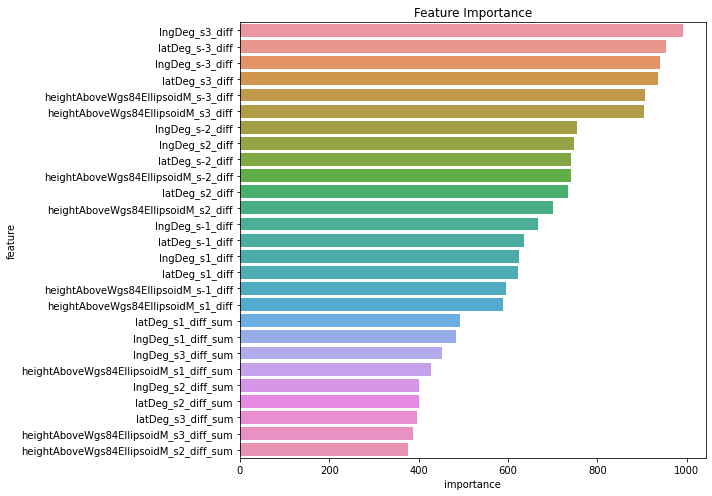

In [19]:
plt.figure(figsize=(10, 7))
sns.barplot(x="importance", y="feature", data=imp_mean.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.tight_layout()

In [20]:
tmp[['millisSinceGpsEpoch', 'speedMps', 'pred']].to_csv('check.csv')

<AxesSubplot:>

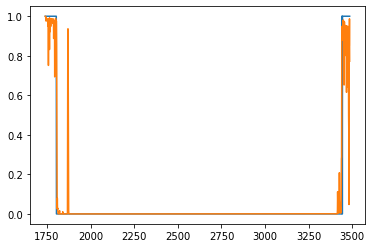

In [21]:
tmp['isSpeed0'].plot()
tmp['pred'].plot()

In [22]:
from sklearn import metrics
from sklearn.metrics import roc_curve

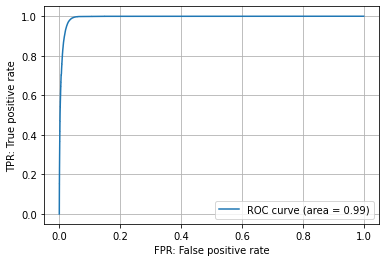

In [23]:
fpr, tpr, thresholds = roc_curve(oof['isSpeed0'], oof['pred'])
auc = metrics.auc(fpr, tpr)
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()
plt.show()

In [24]:
print(auc)

0.9937630430389502


<AxesSubplot:>

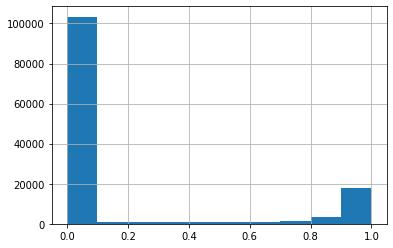

In [25]:
oof['pred'].hist()

In [26]:
oof

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,speedMps,isSpeed0,latDeg_s1,...,latDeg_s1_diff_sum,latDeg_s2_diff_sum,latDeg_s3_diff_sum,lngDeg_s1_diff_sum,lngDeg_s2_diff_sum,lngDeg_s3_diff_sum,heightAboveWgs84EllipsoidM_s1_diff_sum,heightAboveWgs84EllipsoidM_s2_diff_sum,heightAboveWgs84EllipsoidM_s3_diff_sum,pred
0,2020-05-14-US-MTV-1,Pixel4,1273529463442,37.423575,-122.094091,-34.06,2020-05-14-US-MTV-1_Pixel4,0.0,1.0,NaN,...,-0.000002,-4.000000e-07,-7.700000e-06,9.600000e-06,0.000029,5.880000e-05,-0.77,-3.84,-5.07,0.999887
1,2020-05-14-US-MTV-1,Pixel4,1273529464442,37.423578,-122.094101,-33.29,2020-05-14-US-MTV-1_Pixel4,0.0,1.0,37.423575,...,0.000007,1.900000e-06,3.000000e-07,3.000000e-07,0.000020,3.320000e-05,-1.53,-1.99,-0.79,0.999892
2,2020-05-14-US-MTV-1,Pixel4,1273529465442,37.423573,-122.094111,-30.99,2020-05-14-US-MTV-1_Pixel4,0.0,1.0,37.423578,...,-0.000014,-2.170000e-05,-2.650000e-05,3.000000e-07,-0.000016,-9.000001e-07,4.14,10.71,13.29,0.999215
3,2020-05-14-US-MTV-1,Pixel4,1273529466442,37.423583,-122.094121,-32.83,2020-05-14-US-MTV-1_Pixel4,0.0,1.0,37.423573,...,0.000013,2.200000e-05,3.950000e-05,-1.750000e-05,-0.000032,-6.930000e-05,-0.18,1.02,2.94,0.884884
4,2020-05-14-US-MTV-1,Pixel4,1273529467442,37.423579,-122.094114,-34.49,2020-05-14-US-MTV-1_Pixel4,0.0,1.0,37.423583,...,-0.000002,1.080000e-05,2.350000e-05,1.980000e-05,0.000017,6.800000e-06,-2.58,-7.05,-11.14,0.986505
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131337,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760315000,37.334460,-121.899600,-8.09,2021-04-29-US-SJC-2_SamsungS20Ultra,0.0,1.0,37.334457,...,-0.000010,-4.930000e-05,-9.210000e-05,-6.600000e-06,-0.000022,-3.630000e-05,-2.68,-2.07,-1.90,0.807906
131338,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760316000,37.334472,-121.899583,-7.59,2021-04-29-US-SJC-2_SamsungS20Ultra,0.0,1.0,37.334460,...,-0.000007,-1.440000e-05,-2.340000e-05,3.070000e-05,0.000058,4.830000e-05,1.26,0.72,1.62,0.946789
131339,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760317000,37.334491,-121.899597,-8.35,2021-04-29-US-SJC-2_SamsungS20Ultra,0.0,1.0,37.334472,...,0.000015,5.270000e-05,8.670000e-05,-2.800000e-05,-0.000052,-3.950000e-05,-0.38,-1.35,-3.79,0.954457
131340,2021-04-29-US-SJC-2,SamsungS20Ultra,1303760318000,37.334495,-121.899583,-8.73,2021-04-29-US-SJC-2_SamsungS20Ultra,0.0,1.0,37.334491,...,0.000014,3.620000e-05,7.120000e-05,1.000000e-06,0.000001,1.770000e-05,-1.47,-2.61,-3.25,0.967380


In [27]:
os.makedirs(OUTPUT + '/speed0_pred/train', exist_ok=True)
phones = oof['phone'].unique()

for phone in phones:
    fig, axes = plt.subplots(figsize=(50, 20), nrows=2,sharex=True)
    tmp = oof[oof['phone']==phone].copy()

    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['speedMps'], label='speedMps')

    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['isSpeed0'], label='isSpeed0')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')

    axes[0].legend(loc='lower right')
    axes[1].legend(loc='lower right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    axes[1].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/speed0_pred/train/' + phone + '.png')
    plt.close()

In [28]:
os.makedirs(OUTPUT + '/speed0_pred/test', exist_ok=True)
phones = test['phone'].unique()

for phone in phones:
    fig, axes = plt.subplots(figsize=(50, 20), nrows=2,sharex=True)
    tmp = test[test['phone']==phone].copy()

    axes[0].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')
    axes[1].plot(tmp['millisSinceGpsEpoch'], tmp['pred'], label='pred')

    axes[0].legend(loc='lower right')
    axes[0].grid(color='g', linestyle=':', linewidth=0.3)
    fig.suptitle(phone, fontsize=16)
    fig.savefig(OUTPUT + '/speed0_pred/test/' + phone + '.png')
    plt.close()

In [29]:
train_speed0 = oof[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'pred']].copy()
test_speed0 = test[['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'pred']].copy()

train_speed0['isSpeed0'] = 0
test_speed0['isSpeed0'] = 0
train_speed0.loc[train_speed0['pred']>0.5, 'isSpeed0'] = 1
test_speed0.loc[test_speed0['pred']>0.5, 'isSpeed0'] = 1

In [30]:
train_speed0.to_csv(OUTPUT + '/train_speed0.csv', index=False)
test_speed0.to_csv(OUTPUT + '/test_speed0.csv', index=False)

# 学習

In [31]:
base_train = pd.read_csv(INPUT + '/' + 'baseline_locations_train.csv')
base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
sample_sub = pd.read_csv(INPUT + '/' + 'sample_submission.csv')

In [32]:
# ground_truth
p = pathlib.Path(INPUT)
gt_files = list(p.glob('train/*/*/ground_truth.csv'))
print('ground_truth.csv count : ', len(gt_files))

gts = []
for gt_file in tqdm(gt_files):
    gts.append(pd.read_csv(gt_file))
ground_truth = pd.concat(gts)

display(ground_truth.head())

ground_truth.csv count :  73


  0%|          | 0/73 [00:00<?, ?it/s]

,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,timeSinceFirstFixSeconds,hDop,vDop,speedMps,courseDegree
0,2020-05-21-US-MTV-2,Pixel4,1274131364434,37.628927,-122.426295,65.36,64.43,2.6,0.0,0.0,154.3
1,2020-05-21-US-MTV-2,Pixel4,1274131365434,37.628927,-122.426295,65.36,65.43,2.6,0.0,0.0,154.3
2,2020-05-21-US-MTV-2,Pixel4,1274131366434,37.628927,-122.426295,65.36,66.43,2.6,0.0,0.0,154.3
3,2020-05-21-US-MTV-2,Pixel4,1274131367434,37.628927,-122.426295,65.36,67.43,2.6,0.0,0.0,154.3
4,2020-05-21-US-MTV-2,Pixel4,1274131368434,37.628927,-122.426295,65.36,68.43,2.6,0.0,0.0,154.3


In [33]:
def add_distance_diff(df):
    df['latDeg_prev'] = df['latDeg'].shift(1)
    df['latDeg_next'] = df['latDeg'].shift(-1)
    df['lngDeg_prev'] = df['lngDeg'].shift(1)
    df['lngDeg_next'] = df['lngDeg'].shift(-1)
    df['phone_prev'] = df['phone'].shift(1)
    df['phone_next'] = df['phone'].shift(-1)
    
    df['dist_prev'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_prev'], df['lngDeg_prev'])
    df['dist_next'] = calc_haversine(df['latDeg'], df['lngDeg'], df['latDeg_next'], df['lngDeg_next'])
    
    df.loc[df['phone']!=df['phone_prev'], ['latDeg_prev', 'lngDeg_prev', 'dist_prev']] = np.nan
    df.loc[df['phone']!=df['phone_next'], ['latDeg_next', 'lngDeg_next', 'dist_next']] = np.nan
    
    return df

In [34]:
# reject outlier
train_ro = add_distance_diff(base_train)
th = 50
train_ro.loc[((train_ro['dist_prev'] > th) & (train_ro['dist_next'] > th)), ['latDeg', 'lngDeg']] = np.nan
train_ro.to_csv(OUTPUT + '/train_ro.csv', index=False)

In [35]:
def sp0_process(df, sp0_result):
    df = df.merge(sp0_result, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    df['group'] = df.groupby('phone').cumcount()
    df.loc[(df['group']>0)&(df['isSpeed0']==1),'group'] = np.nan
    df['group'] = df['group'].fillna(method='ffill')
    df[['latDeg', 'lngDeg']] = df.groupby(['phone', 'group'])[['latDeg','lngDeg']].transform('mean')
    return df

In [36]:
train_sp0 = sp0_process(train_ro, train_speed0)
train_sp0.to_csv(OUTPUT + '/train_sp0.csv', index=False)

In [37]:
import simdkalman

In [38]:
T = 1.0
state_transition = np.array([[1, 0, T, 0, 0.5 * T ** 2, 0], [0, 1, 0, T, 0, 0.5 * T ** 2], [0, 0, 1, 0, T, 0],
                             [0, 0, 0, 1, 0, T], [0, 0, 0, 0, 1, 0], [0, 0, 0, 0, 0, 1]])
process_noise = np.diag([1e-5, 1e-5, 5e-6, 5e-6, 1e-6, 1e-6]) + np.ones((6, 6)) * 1e-9
observation_model = np.array([[1, 0, 0, 0, 0, 0], [0, 1, 0, 0, 0, 0]])
observation_noise = np.diag([5e-5, 5e-5]) + np.ones((2, 2)) * 1e-9

kf = simdkalman.KalmanFilter(
        state_transition = state_transition,
        process_noise = process_noise,
        observation_model = observation_model,
        observation_noise = observation_noise)

def apply_kf_smoothing(df, kf_=kf):
    unique_paths = df[['collectionName', 'phoneName']].drop_duplicates().to_numpy()
    for collection, phone in unique_paths:
        cond = np.logical_and(df['collectionName'] == collection, df['phoneName'] == phone)
        data = df[cond][['latDeg', 'lngDeg']].to_numpy()
        data = data.reshape(1, len(data), 2)
        smoothed = kf_.smooth(data)
        df.loc[cond, 'latDeg'] = smoothed.states.mean[0, :, 0]
        df.loc[cond, 'lngDeg'] = smoothed.states.mean[0, :, 1]
    return df

In [39]:
cols = ['collectionName', 'phoneName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']
train_ro_kf = apply_kf_smoothing(train_sp0[cols])
train_ro_kf.to_csv(OUTPUT + '/train_ro_kf.csv', index=False)

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [40]:
def percentile50(x):
    return np.percentile(x, 50)
def percentile95(x):
    return np.percentile(x, 95)

In [41]:
def get_train_score(df, gt):
    gt = gt.rename(columns={'latDeg':'latDeg_gt', 'lngDeg':'lngDeg_gt'})
    df = df.merge(gt, on=['collectionName', 'phoneName', 'millisSinceGpsEpoch'], how='inner')
    # calc_distance_error
    df['err'] = calc_haversine(df['latDeg_gt'], df['lngDeg_gt'], df['latDeg'], df['lngDeg'])
    # calc_evaluate_score
    df['phone'] = df['collectionName'] + '_' + df['phoneName']
    res = df.groupby('phone')['err'].agg([percentile50, percentile95])
    res['p50_p90_mean'] = (res['percentile50'] + res['percentile95']) / 2 
    score = res['p50_p90_mean'].mean()
    return score

In [42]:
print('result : ', get_train_score(train_ro_kf, ground_truth))

result :  4.367647466628065


In [43]:
def make_lerp_data(df):
    '''
    Generate interpolated lat,lng values for different phone times in the same collection.
    '''
    org_columns = df.columns
    
    # Generate a combination of time x collection x phone and combine it with the original data (generate records to be interpolated)
    time_list = df[['collectionName', 'millisSinceGpsEpoch']].drop_duplicates()
    phone_list =df[['collectionName', 'phoneName']].drop_duplicates()
    tmp = time_list.merge(phone_list, on='collectionName', how='outer')
    
    lerp_df = tmp.merge(df, on=['collectionName', 'millisSinceGpsEpoch', 'phoneName'], how='left')
    lerp_df['phone'] = lerp_df['collectionName'] + '_' + lerp_df['phoneName']
    lerp_df = lerp_df.sort_values(['phone', 'millisSinceGpsEpoch'])
    
    # linear interpolation
    lerp_df['latDeg_prev'] = lerp_df['latDeg'].shift(1)
    lerp_df['latDeg_next'] = lerp_df['latDeg'].shift(-1)
    lerp_df['lngDeg_prev'] = lerp_df['lngDeg'].shift(1)
    lerp_df['lngDeg_next'] = lerp_df['lngDeg'].shift(-1)
    lerp_df['phone_prev'] = lerp_df['phone'].shift(1)
    lerp_df['phone_next'] = lerp_df['phone'].shift(-1)
    lerp_df['time_prev'] = lerp_df['millisSinceGpsEpoch'].shift(1)
    lerp_df['time_next'] = lerp_df['millisSinceGpsEpoch'].shift(-1)
    # Leave only records to be interpolated
    lerp_df = lerp_df[(lerp_df['latDeg'].isnull())&(lerp_df['phone']==lerp_df['phone_prev'])&(lerp_df['phone']==lerp_df['phone_next'])].copy()
    # calc lerp
    lerp_df['latDeg'] = lerp_df['latDeg_prev'] + ((lerp_df['latDeg_next'] - lerp_df['latDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    lerp_df['lngDeg'] = lerp_df['lngDeg_prev'] + ((lerp_df['lngDeg_next'] - lerp_df['lngDeg_prev']) * ((lerp_df['millisSinceGpsEpoch'] - lerp_df['time_prev']) / (lerp_df['time_next'] - lerp_df['time_prev']))) 
    
    # Leave only the data that has a complete set of previous and next data.
    lerp_df = lerp_df[~lerp_df['latDeg'].isnull()]
    
    return lerp_df[org_columns]

In [44]:
def calc_mean_pred(df, lerp_df):
    '''
    Make a prediction based on the average of the predictions of phones in the same collection.
    '''
    add_lerp = pd.concat([df, lerp_df])
    mean_pred_result = add_lerp.groupby(['collectionName', 'millisSinceGpsEpoch'])[['latDeg', 'lngDeg']].mean().reset_index()
    mean_pred_df = df[['collectionName', 'phoneName', 'millisSinceGpsEpoch']].copy()
    mean_pred_df = mean_pred_df.merge(mean_pred_result[['collectionName', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']], on=['collectionName', 'millisSinceGpsEpoch'], how='left')
    return mean_pred_df

In [45]:
train_lerp = make_lerp_data(train_ro_kf)
train_mean_pred = calc_mean_pred(train_ro_kf, train_lerp)
train_mean_pred.to_csv(OUTPUT + '/train_mean_pred.csv', index=False)

In [46]:
print('+ phones_mean_pred : ', get_train_score(train_mean_pred, ground_truth))

+ phones_mean_pred :  3.963164235398338


# make_sub

In [47]:
base_test = pd.read_csv(INPUT + '/' + 'baseline_locations_test.csv')
base_test = add_distance_diff(base_test)
th = 50
base_test.loc[((base_test['dist_prev'] > th) & (base_test['dist_next'] > th)), ['latDeg', 'lngDeg']] = np.nan
base_test = sp0_process(base_test, test_speed0)

test_kf = apply_kf_smoothing(base_test)

test_lerp = make_lerp_data(test_kf)
test_mean_pred = calc_mean_pred(test_kf, test_lerp)

sample_sub['latDeg'] = test_mean_pred['latDeg']
sample_sub['lngDeg'] = test_mean_pred['lngDeg']
sample_sub.to_csv(OUTPUT + '/submission.csv', index=False)

In [48]:
print(sample_sub.shape)
sample_sub.head()

(91486, 4)


,phone,millisSinceGpsEpoch,latDeg,lngDeg
0,2020-05-15-US-MTV-1_Pixel4,1273608785432,37.416593,-122.082024
1,2020-05-15-US-MTV-1_Pixel4,1273608786432,37.416600,-122.082048
2,2020-05-15-US-MTV-1_Pixel4,1273608787432,37.416604,-122.082062
3,2020-05-15-US-MTV-1_Pixel4,1273608788432,37.416607,-122.082068
4,2020-05-15-US-MTV-1_Pixel4,1273608789432,37.416607,-122.082071
